In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


pd.set_option('display.float_format', lambda x: '%.2f' % x)
df = pd.read_csv("data.csv", encoding='ISO-8859-1')


print(df.shape)
df.head()


(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.00,United Kingdom


In [13]:
# Parse InvoiceDate correctly (month/day/year hour:minute)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M', errors='coerce')

bad_dates = df['InvoiceDate'].isna().sum()
print(f"InvoiceDate parse failures: {bad_dates}")

df = df.dropna(subset=['InvoiceDate', 'CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(int)
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

# remove cancelled invoices 0
df = df[~df['InvoiceNo'].str.startswith('C')]

# remove neg quantities / prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

df = df.drop_duplicates()

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

print("CLEAN shape:", df.shape)
print("Date range:", df['InvoiceDate'].min(), "to", df['InvoiceDate'].max())
print("Unique customers:", df['CustomerID'].nunique())
print("Total transactions (invoices):", df['InvoiceNo'].nunique())

# top 5 
df.head()


InvoiceDate parse failures: 0
CLEAN shape: (166363, 9)
Date range: 2010-01-12 08:26:00 to 2011-12-10 17:19:00
Unique customers: 2997
Total transactions (invoices): 7961


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34


In [7]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Reference date:", reference_date)

# RFM calculation
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                     # Frequency (# invoices)
    'TotalPrice': 'sum'                                         # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Quick look at summary stats
print(rfm.shape)
rfm.describe().round(1).T


Reference date: 2011-12-11 17:19:00
(2997, 4)


,count,mean,std,min,25%,50%,75%,max
CustomerID,2997.00,15291.90,1722.60,12347.00,13809.00,15251.00,16791.00,18287.00
Recency,2997.00,155.40,140.10,1.00,40.00,125.00,219.00,698.00
Frequency,2997.00,2.70,4.00,1.00,1.00,2.00,3.00,106.00
Monetary,2997.00,1289.80,5273.00,5.90,244.40,466.30,1064.30,168469.60


In [14]:
rfm['R_rank'] = rfm['Recency'].rank(method='first')
rfm['F_rank'] = rfm['Frequency'].rank(method='first')
rfm['M_rank'] = rfm['Monetary'].rank(method='first')

# Recency
rfm['R_score'] = pd.qcut(rfm['R_rank'], 5, labels=[5,4,3,2,1]).astype(int)

# Frequency & Monetary
rfm['F_score'] = pd.qcut(rfm['F_rank'], 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_score'] = pd.qcut(rfm['M_rank'], 5, labels=[1,2,3,4,5]).astype(int)

# single score
rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm['RFM_Sum'] = rfm[['R_score','F_score','M_score']].sum(axis=1)

#  top customers
rfm.sort_values('RFM_Sum', ascending=False).head(10)


,CustomerID,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,R_score,F_score,M_score,RFM_Score,RFM_Sum,Segment
27,12395,6,7,1762.63,242.00,2799.00,2596.00,5,5,5,555,15,Champions
20,12381,1,5,1845.31,1.00,2619.00,2620.00,5,5,5,555,15,Champions
475,13267,10,11,2592.29,351.00,2921.00,2777.00,5,5,5,555,15,Champions
473,13265,2,4,1787.30,80.00,2466.00,2604.00,5,5,5,555,15,Champions
472,13263,6,13,2726.68,251.00,2946.00,2791.00,5,5,5,555,15,Champions
2988,18272,4,3,1761.36,202.00,2435.00,2595.00,5,5,5,555,15,Champions
2976,18245,6,3,1395.63,296.00,2434.00,2443.00,5,5,5,555,15,Champions
9,12362,31,5,2135.79,445.00,2618.00,2693.00,5,5,5,555,15,Champions
2965,18226,33,5,2251.38,597.00,2737.00,2719.00,5,5,5,555,15,Champions
773,13854,2,11,3696.87,88.00,2924.00,2865.00,5,5,5,555,15,Champions


In [15]:
def rfm_segment(row):
    s = row['RFM_Sum']
    if s >= 13:
        return 'Champions'
    elif s >= 10:
        return 'Loyal'
    elif s >= 7:
        return 'Potential'
    elif s >= 5:
        return 'At Risk'
    else:
        return 'Lost'

rfm['Segment'] = rfm.apply(rfm_segment, axis=1)

#customers per segment
seg_counts = rfm['Segment'].value_counts().reset_index()
seg_counts.columns = ['Segment','Count']
seg_counts


,Segment,Count
0,Potential,821
1,Loyal,693
2,At Risk,616
3,Champions,607
4,Lost,260


C:\Users\pc\AppData\Local\Temp\ipykernel_8672\2751477681.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Segment', y='Count', data=seg_counts, palette='viridis')


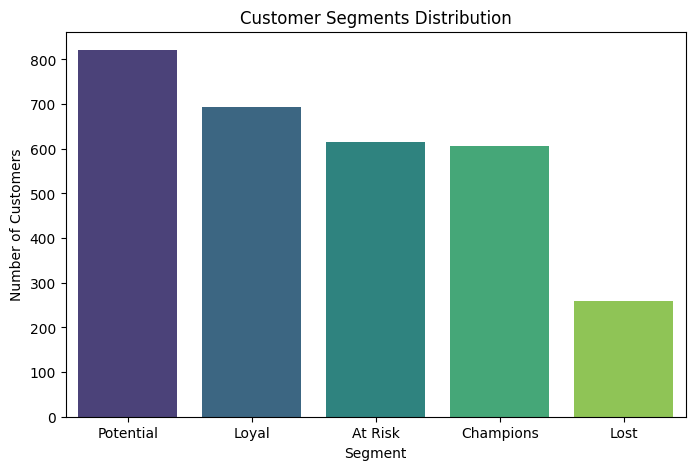

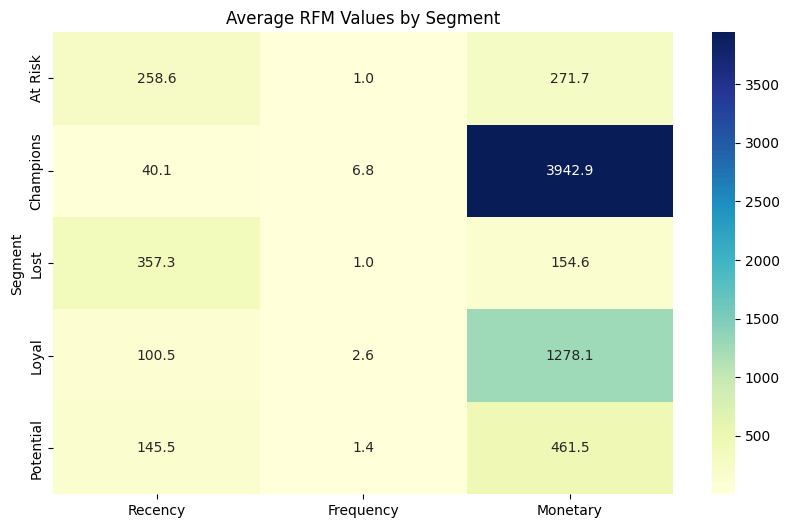

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

#(bar chart)
plt.figure(figsize=(8,5))
sns.barplot(x='Segment', y='Count', data=seg_counts, palette='viridis')
plt.title('Customer Segments Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.show()

# RFM Heatmap 
rfm_summary = rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean().reset_index()

plt.figure(figsize=(10,6))
sns.heatmap(rfm_summary.set_index('Segment'), annot=True, fmt=".1f", cmap='YlGnBu')
plt.title('Average RFM Values by Segment')
plt.show()


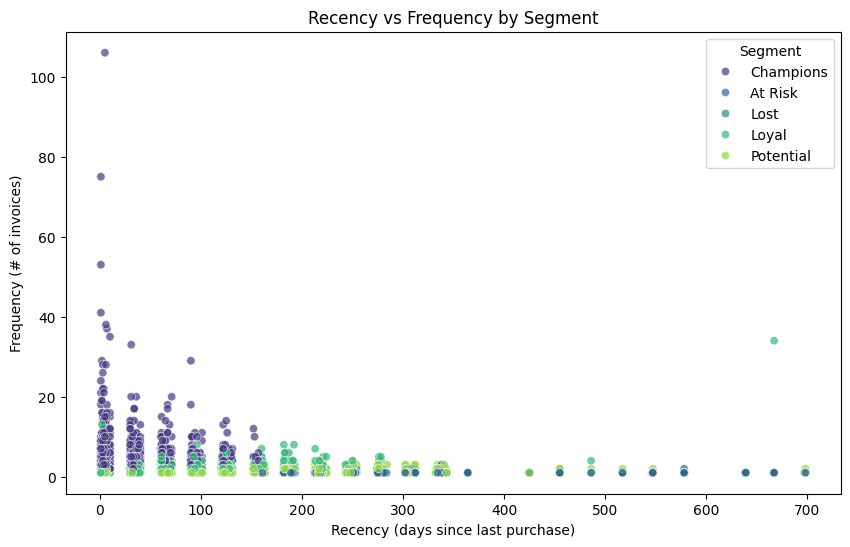

In [11]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=rfm,
    x='Recency',
    y='Frequency',
    hue='Segment',
    palette='viridis',
    alpha=0.7
)
plt.title('Recency vs Frequency by Segment')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Frequency (# of invoices)')
plt.legend(title='Segment')
plt.show()


In [ ]:
################################################################ Marketing Recommendations Based on RFM Segmentation

I segmented customers into 5 groups using RFM analysis (Recency, Frequency, Monetary).  
Below are suggested simple strategies for each segment:

###### Champions (607 customers, RFM 13–15)
- VIP treatment: exclusive previews, early access to new products.
- Reward loyalty with points, gifts, or free shipping.
- Encourage referrals (they are brand advocates).

###### Loyal (693 customers, RFM 10–12)
- Upsell and cross-sell with personalized recommendations.
- Offer subscription bundles or seasonal deals.
- Keep engagement strong with newsletters or loyalty programs.

####### Potential (821 customers, RFM 7–9)
- Convert them into Loyal with small discounts or coupons.
- Personalized product suggestions (“You may also like…”).
- Encourage repeat purchases via email reminders.

###### At Risk (616 customers, RFM 5–6)
- Send win-back campaigns with strong incentives (discounts, free gifts).
- Ask for feedback on why they stopped buying.
- Limited-time offers to create urgency.

#########Lost (260 customers, RFM <5)
- Send reactivation emails with a “we miss you” campaign.
- Special large discount or one-time deal.
- If unresponsive, reduce marketing investment (low ROI).
